In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

import warnings
warnings.filterwarnings(action = 'ignore')

In [5]:
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


# 표본이 주어졌을 때, 모평균을 추정하기: 정규분포와 라플라스 분포의 경우
표본 평균의 분포뿐만 아니라, 표본의 중앙값, 표본의 분산, 표본의 표준편차, 표본의 평균절대편차에 대해서도 분포를 알아볼 수 있다.

앞의 "모분포 vs 표본분포"에서 구한 모집단A에서 크기 3표본을 추출했을 때, 표본평균과 표본중앙값을 비교해 보자.

In [6]:
def var_a(any_num,a):
  sum_list =[]
  for num in a:
    input_n = (num-any_num)**2 
    sum_list.append(input_n)
  
  return sum(sum_list)/len(a)

# 모분포 만들기
uni=[-1,-1,0,0,0,0,0,1,1,1]

avg = sum(uni)/len(uni)
middle = 0 
var = np.around(np.var(uni),2)
std = np.around(np.std(uni),2)
aad = var_a(np.median(uni),uni)

sample_list=[]
sample_list=list(product(set(uni),set(uni),set(uni)))

sample_df=pd.DataFrame(columns=['x1','x2','x3','확률','평균','중앙값','분산','표준편차','평균절대편차'])

for idx in range(len(sample_list)):
  x1 = sample_list[idx][0]
  x2 = sample_list[idx][1]
  x3 = sample_list[idx][2]

  x1_pro=uni.count(x1)/len(uni)
  x2_pro=uni.count(x2)/len(uni)
  x3_pro=uni.count(x3)/len(uni)

  # 관측치 대입
  sample_df.loc[idx,'x1'] = x1
  sample_df.loc[idx,'x2'] = x2
  sample_df.loc[idx,'x3'] = x3


  #확률 대입
  sample_df.loc[idx,'확률'] = np.around(x1_pro * x2_pro * x3_pro,3)

  #평균 대입
  sample_df.loc[idx,'평균'] = np.around(np.mean(sample_list[idx]),3)

  #중앙값 대입
  sample_df.loc[idx,'중앙값'] = np.median(sample_list[idx])

  #분산값 대입
  sample_df.loc[idx,'분산'] = np.var(sample_list[idx])

  #표준편차값 대입
  sample_df.loc[idx,'표준편차'] = np.std(sample_list[idx])

  #평균절대편차값 대입
  sample_df.loc[idx,'평균절대편차'] = var_a(np.median(sample_list[idx]),sample_list[idx])


sample_df = sample_df.sort_values(['x1','x2','x3']).reset_index(drop=True)

In [7]:
mean_dev=sample_df.groupby(['평균'])['확률'].sum().reset_index()
mean_dev.T

,0,1,2,3,4,5,6
평균,-1.000,-0.667,-0.333,0.000,0.333,0.667,1.000
확률,0.008,0.060,0.186,0.305,0.279,0.135,0.027


In [8]:
mid_dev=sample_df.groupby(['중앙값'])['확률'].sum().reset_index()
mid_dev.T

,0,1,2
중앙값,-1.000,0.00,1.000
확률,0.104,0.68,0.216


In [9]:
df=pd.merge(mean_dev,mid_dev,left_on='평균',right_on='중앙값',how='left')
df.drop('중앙값',axis=1,inplace=True)
df.rename(columns={'평균':'분포','확률_x':'표본평균','확률_y':'표본중앙값'},inplace=True)
graph_df=pd.melt(df,id_vars=['분포'])

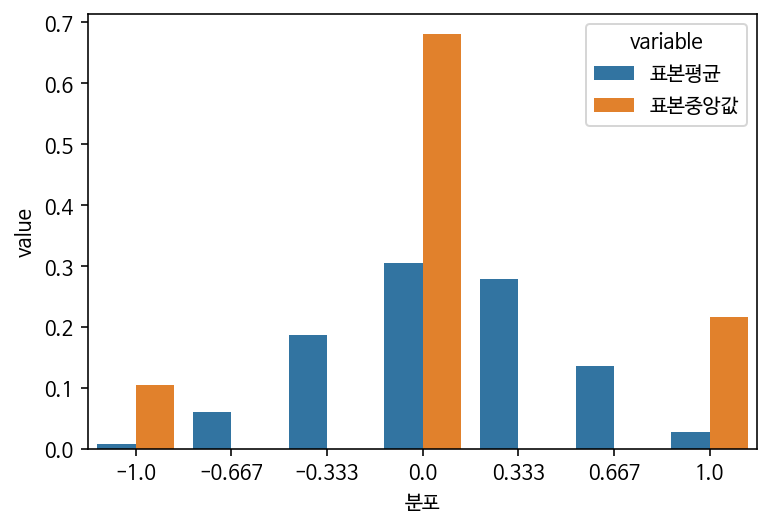

In [10]:
sns.barplot(graph_df['분포'],graph_df['value'],hue=graph_df['variable'])

표본중앙값의 분포에 대해서도 평균, 중앙값, 분산, 표준편차, 평균절대편차 등을 구할 수 있다.

In [11]:
md_mean = sum(mid_dev['중앙값']*mid_dev['확률'])
md_median = 0  # 누적확률분포로 생각해보면 0.5일 때 값은 0 이기 때문임
md_var = np.around(sum(((mid_dev['중앙값'] - md_mean)**2)*mid_dev['확률']),3) # ((관측치-평균)**2) * P
md_std = np.around(md_var**(1/2),3)
md_mad = np.around(sum(abs(mid_dev['중앙값'] - md_mean)*mid_dev['확률']),3)

In [12]:
print('표본중앙값의 평균',md_mean)
print('표본중앙값의 중앙값',md_median)
print('표본중앙값의 분산',md_var)
print('표본중앙값의 표준편차',md_std)
print('표본중앙값의 평균절대편차',md_mad)

표본중앙값의 평균 0.112
표본중앙값의 중앙값 0
표본중앙값의 분산 0.307
표본중앙값의 표준편차 0.554
표본중앙값의 평균절대편차 0.384


알수 있듯이, 표본중앙값의 평균은 0.112로 모중앙값(0) 보다는 모평균인 0.1에 가깝다. 따라서 각각의 표본에 대해 표본 중앙값을 구했다면, 그에대한 평균보다는 중앙값을 사용하여 모중앙값을 추정하는 것이 바람직하다.

한번 10개의 Sample을 무작위로 뽑아서 표본 중앙값의 분포를 살펴보자.

In [13]:
# 표본크기 3을 추출하여 중앙값을 구하자
import random
choiceList = [random.choice(uni) for i in range(3)]
print('표본크기 3인 표본 중 하나',choiceList)

# 이제 이것을 10번 반복하여 10개의 표본중앙값을 얻어보자.
sample_mid_list=[]
for _ in range(10):
  choiceList = [random.choice(uni) for i in range(3)]

  # 중앙값을 구하기 위해 정렬후 가운데값 출력
  choiceList.sort()
  mid = choiceList[1]
  sample_mid_list.append(mid)

print('표본크기 3 표본을 10번 반복하여 얻은 10개의 표본 중앙값', sample_mid_list)
print('표본 중앙값의 평균',sum(sample_mid_list)/len(sample_mid_list))
sample_mid_list.sort() #중앙값을 구하기 위해 정렬
print('표본 중앙값의 중앙값',(sample_mid_list[4]+sample_mid_list[5])/2)

표본크기 3인 표본 중 하나 [-1, 1, 1]
표본크기 3 표본을 10번 반복하여 얻은 10개의 표본 중앙값 [1, 0, 0, 0, 1, 1, 0, 1, 0, 0]
표본 중앙값의 평균 0.4
표본 중앙값의 중앙값 0.0


확실히 표본중앙값을 얻었을 때, 평균보다는 중앙값이 정확하다.

여기서 표본중앙값 10개의 중앙값과 평균은 푠 10개를 어떻게 추출하느냐에 따라 달라지는 **확률변수**임을 잊지말자.

그렇기 때문에 확률변수가 어떤 값을 얼마나 잘 반영하는지는 확률변수의 분포의 평균(기댓값) 뿐만 아니라 퍼진 정도(산포측도)도 봐야한다.

---
만약 모평균과 모중앙값이 같을 경우엔, 표본평균과 표본중앙값 중 어떤 것을 써야할까?
- 정규분포와 라플라스의 평균과 중앙값은 같다. 하지만 표본평균과 표본중앙값은 어떤 표본이 추출되느냐에 따라 달라진다.

정규분포, 라플라스 분포 만들기
- 아래의 코드로 간단하게 정규분포를 만들 수 있음.
```
import scipy.stats as stats
stats.norm(0, 1).pdf(x) 
```



In [14]:
import numpy as np

x = np.linspace(-5, 5, 101)
y_nd = (1 / np.sqrt(2 * np.pi)) * np.exp(- x ** 2 / 2) # 정규분포 공식 활용
y_lp = (1 / np.sqrt(2)) * np.exp(- np.sqrt(2)* abs(x)) # 정규분포 공식 활용

정규분포 공식
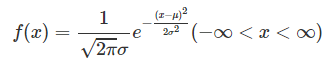

라플라스 분포 공식
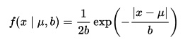

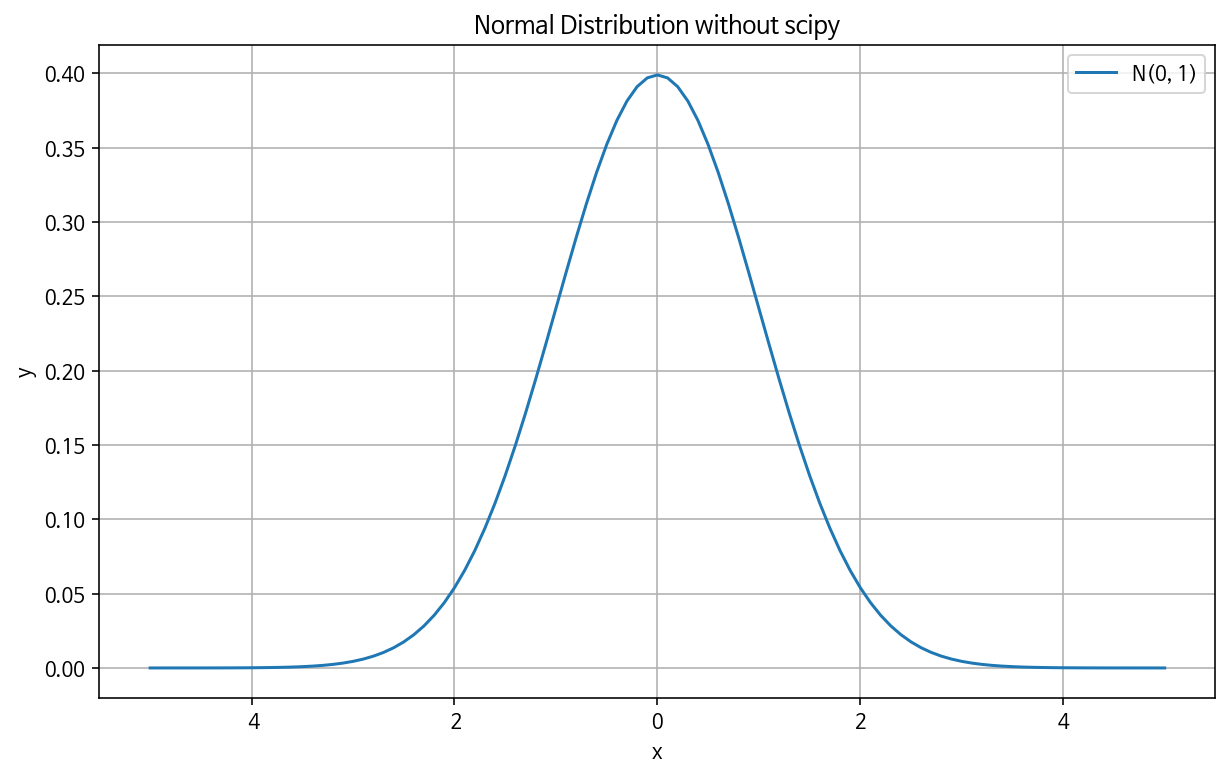

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))          # 플롯 사이즈 지정
plt.plot(x, y_nd)                       
plt.xlabel("x")                      # x축 레이블 지정
plt.ylabel("y")                      # y축 레이블 지정
plt.grid()                           # 플롯에 격자 보이기
plt.title("Normal Distribution without scipy")     # 타이틀 표시
plt.legend(["N(0, 1)"])              # 범례 표시
plt.show()                           # 플롯 보이기

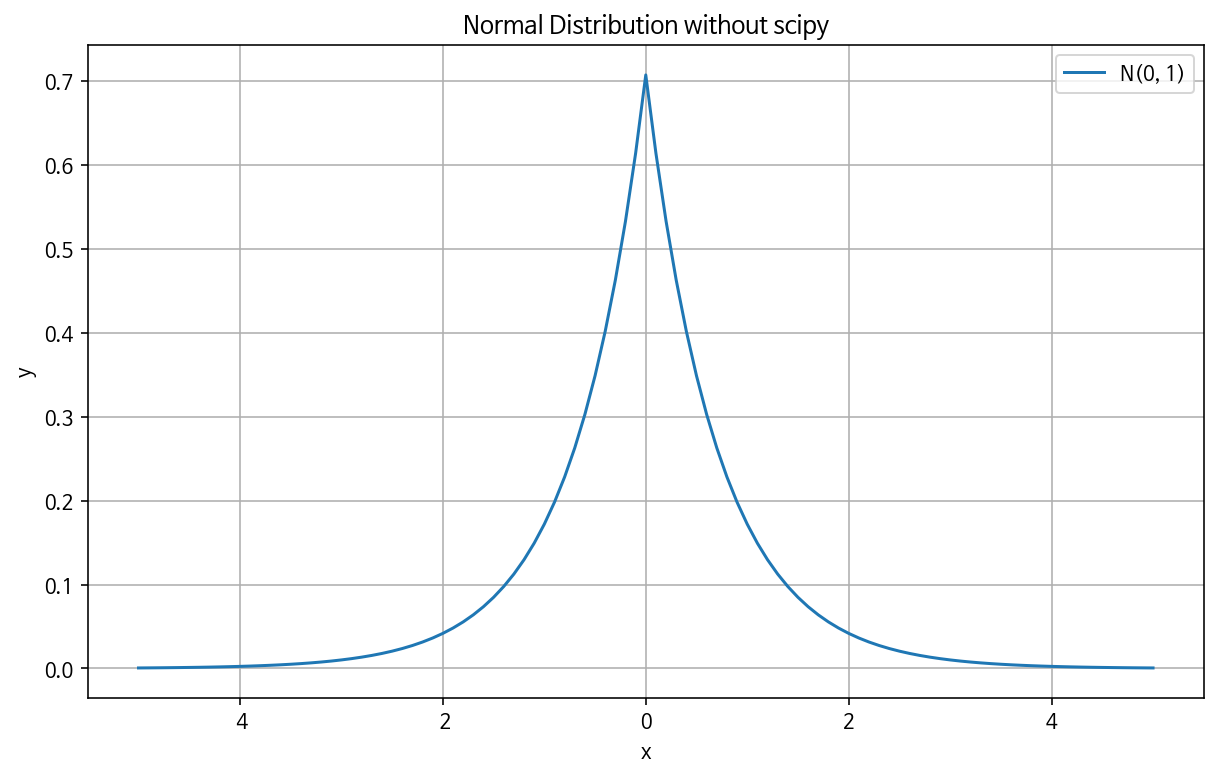

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))          # 플롯 사이즈 지정
plt.plot(x, y_lp)                       
plt.xlabel("x")                      # x축 레이블 지정
plt.ylabel("y")                      # y축 레이블 지정
plt.grid()                           # 플롯에 격자 보이기
plt.title("Normal Distribution without scipy")     # 타이틀 표시
plt.legend(["N(0, 1)"])              # 범례 표시
plt.show()                           # 플롯 보이기

책에 나와있는 공식을 활용해 코드로 만드는 것은 조금 어려울 것 같으니, Numpy의 힘을 빌려보자 ㅎㅎ

아래의 numpy 함수를 이용하면 정규분포, 라플라스분포, 포아송분포, 카이제곱분포, t-분포, f-분포, 균등분포도 쉽게 만들 수가 있다.

In [17]:
# 정규 분포 모집단 만들기(평균 0, 표준편차 1)
loc, scale = 0., 1. 
list_nd = np.random.normal(loc, scale, 1000)

# 라플라스 분포 모집단 만들기(평균 0, 표준편차 1)
loc, scale = 0., 1.
list_ld = np.random.laplace(loc, scale, 1000)

그럼 이제 표본크기 3인 표본을 추출하여 표본 중앙값, 표본 평균값의 "분포" 그래프를 그려보자.

In [19]:
# 표본크기 3을 추출하여 중앙값을 구하자
import random
choiceList = [random.choice(list_nd) for i in range(3)]
print('표본크기 3인 표본 중 하나',choiceList)

# 이제 이것을 1000번 반복하여 1000개의 표본중앙값을 얻어보자.
sample_mid_list=[]
for _ in range(1000):
  choiceList = [random.choice(list_nd) for i in range(3)]

  # 중앙값을 구하기 위해 정렬후 가운데값 출력
  choiceList.sort()
  mid = choiceList[1]
  sample_mid_list.append(mid)

# 이제 이것을 1000번 반복하여 1000개의 표본평균을 얻어보자.
sample_mean_list=[]
for _ in range(1000):
  choiceList = [random.choice(list_nd) for i in range(3)]

  # 평균값 삽입
  mean = sum(choiceList)/len(choiceList)
  sample_mean_list.append(mean)

표본크기 3인 표본 중 하나 [0.4247007417476515, -0.22250448198288555, -0.865567593739616]


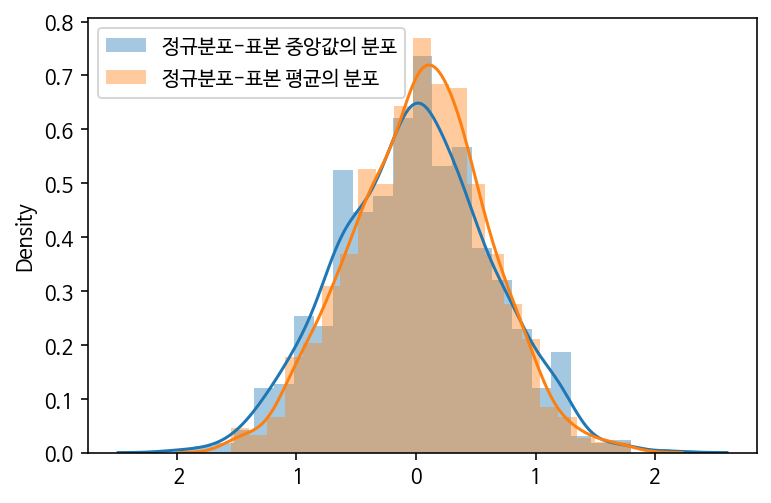

In [20]:
# fig,axes=plt.subplots(1,2)
# ax_0=sns.distplot(sample_mid_list,ax=axes[0])
# ax_0.title('정규분포일 때, 표본 중앙값의 분포')

# ax_1=sns.distplot(sample_mean_list,ax=axes[1])
# ax_1.title('정규분포일 때, 표본 평균의 분포')

# plt.show()

sns.distplot(sample_mid_list, label="정규분포-표본 중앙값의 분포")
sns.distplot(sample_mean_list, label="정규분포-표본 평균의 분포")
plt.legend()

표본평균의 분포가 표본중앙값의 분포보다 조밀한 것을 확인할 수 있다.

In [22]:
# 표본크기 3을 추출하여 중앙값을 구하자
import random
choiceList = [random.choice(list_ld) for i in range(3)]
print('표본크기 3인 표본 중 하나',choiceList)

# 이제 이것을 1000번 반복하여 1000개의 표본중앙값을 얻어보자.
sample_mid_list=[]
for _ in range(1000):
  choiceList = [random.choice(list_ld) for i in range(3)]

  # 중앙값을 구하기 위해 정렬후 가운데값 출력
  choiceList.sort()
  mid = choiceList[1]
  sample_mid_list.append(mid)

# 이제 이것을 1000번 반복하여 1000개의 표본중앙값을 얻어보자.
sample_mean_list=[]
for _ in range(1000):
  choiceList = [random.choice(list_ld) for i in range(3)]

  # 평균값 삽입
  mean = sum(choiceList)/len(choiceList)
  sample_mean_list.append(mean)

표본크기 3인 표본 중 하나 [0.3175412539470291, -0.6529326958229864, -0.7552885854718397]


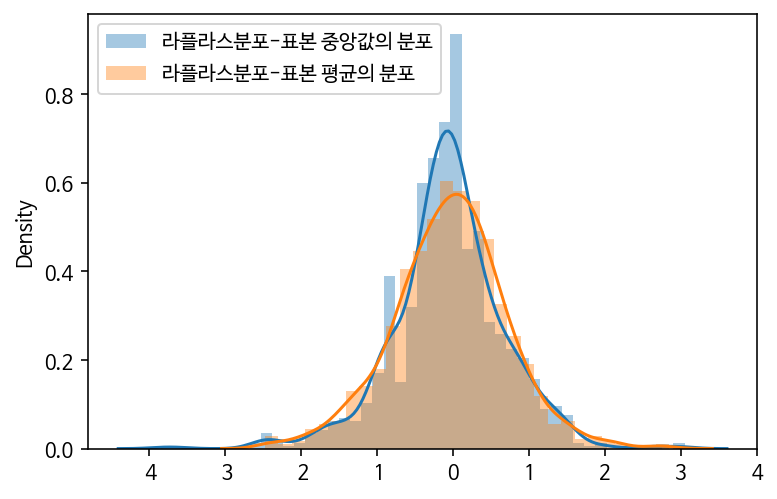

In [23]:
sns.distplot(sample_mid_list, label="라플라스분포-표본 중앙값의 분포")
sns.distplot(sample_mean_list, label="라플라스분포-표본 평균의 분포")
plt.legend()

반면, 라플라스분포에서는 표본 중앙값의 분포가 표본 평균의 분포보다 조밀한 것을 볼 수 있다. 따라서 라플라스 분포일 경우에는 모평균(혹은 모중앙값)을 추정하기 위해 표본중앙값을 쓰는 것이 좀더 정확하다.

**결론적으로 모평균과 모중앙값이 같을 때, 모평균(혹은 모중앙값)을 추정하기 위해서 표본평균을 쓸지, 아니면 표본중앙값을 쓸지는 주어진 모분포의 모양에 따라 달라진다.**

★ 최대 우도 추정치는 표본의 크기가 커질수록 효율적인 추정치로 알려져있다.

이를 확인하기 위해 표본의 개수를 바꿔가며 그래프의 변화를 확인해 보자.

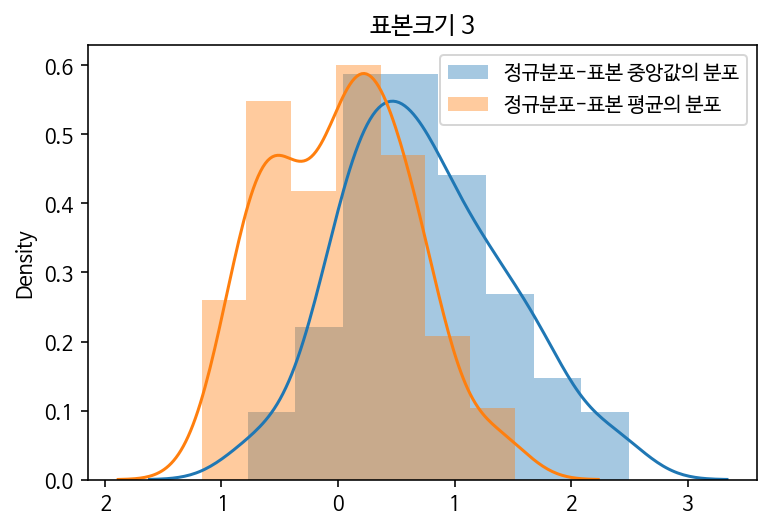

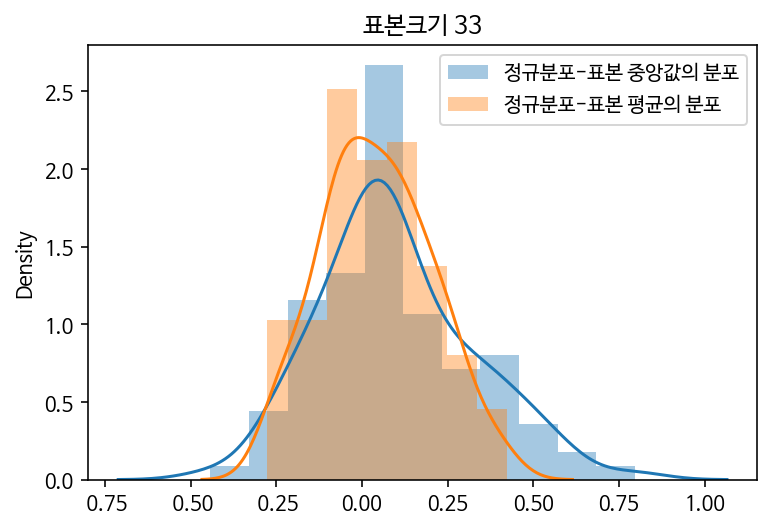

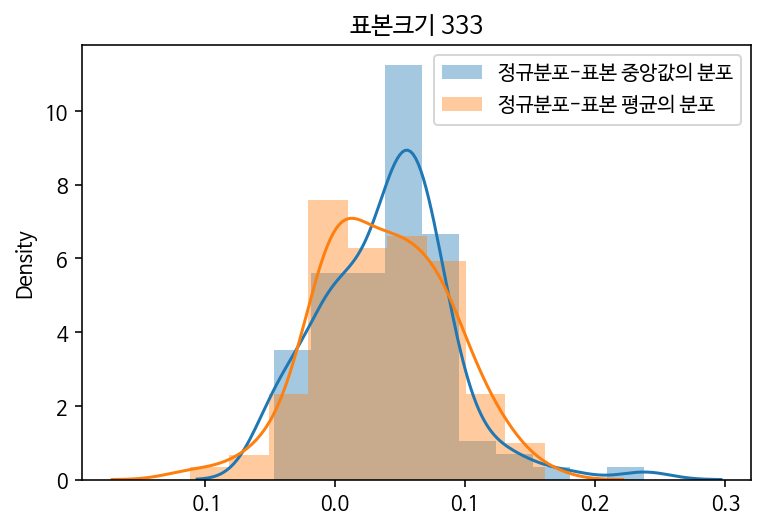

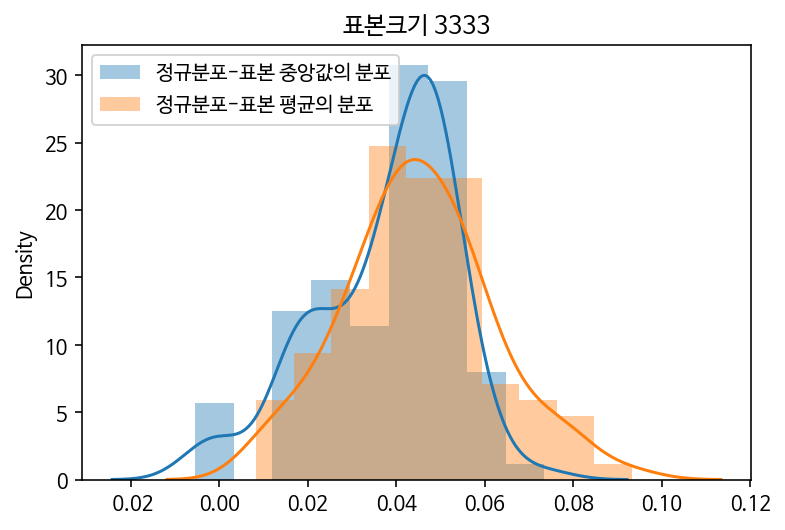

In [24]:
for num in [3,33,333,3333]:
  import random
  choiceList = [random.choice(list_nd) for i in range(num)]
  #print('표본크기 %s'%(num))

  # 이제 이것을 1000번 반복하여 1000개의 표본중앙값을 얻어보자.
  sample_mid_list=[]
  for _ in range(100):
    choiceList = [random.choice(list_nd) for i in range(num)]

    # 중앙값을 구하기 위해 정렬후 가운데값 출력
    choiceList.sort()
    mid_num= int(len(choiceList)/2 +0.5)
    mid = choiceList[mid_num]
    sample_mid_list.append(mid)

  # 이제 이것을 1000번 반복하여 1000개의 표본중앙값을 얻어보자.
  sample_mean_list=[]
  for _ in range(100):
    choiceList = [random.choice(list_nd) for i in range(num)]

    # 평균값 삽입
    mean = sum(choiceList)/len(choiceList)
    sample_mean_list.append(mean)

  plt.title('표본크기 %s'%(num))
  sns.distplot(sample_mid_list, label="정규분포-표본 중앙값의 분포")
  sns.distplot(sample_mean_list, label="정규분포-표본 평균의 분포")
  plt.legend()
  plt.show()

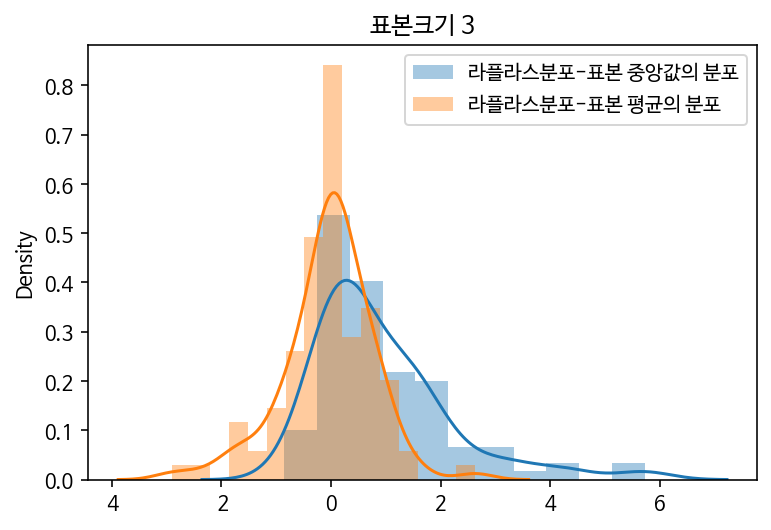

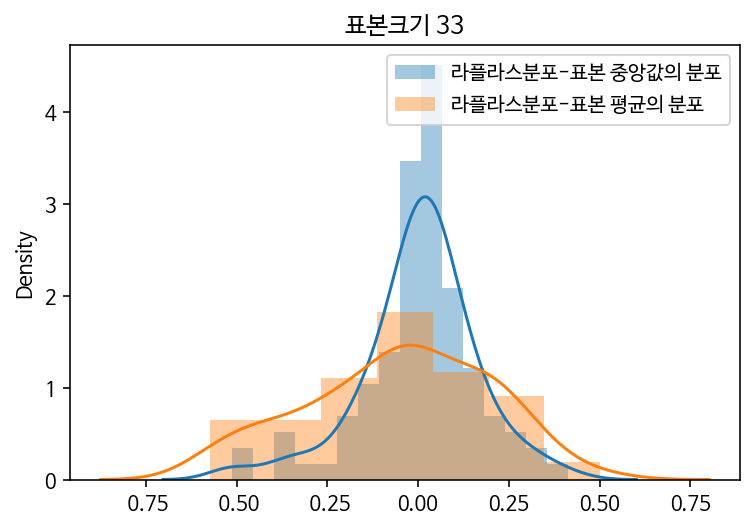

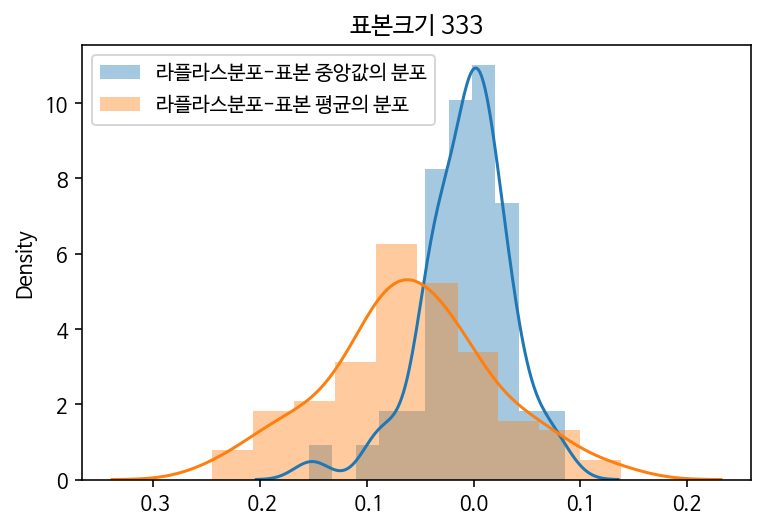

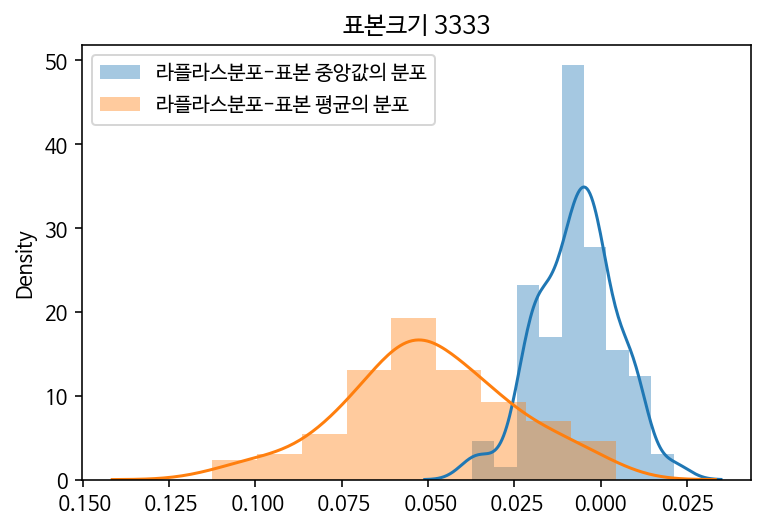

In [25]:
for num in [3,33,333,3333]:
  import random
  choiceList = [random.choice(list_ld) for i in range(num)]
  #print('표본크기 %s'%(num))

  # 이제 이것을 1000번 반복하여 1000개의 표본중앙값을 얻어보자.
  sample_mid_list=[]
  for _ in range(100):
    choiceList = [random.choice(list_ld) for i in range(num)]

    # 중앙값을 구하기 위해 정렬후 가운데값 출력
    choiceList.sort()
    mid_num= int(len(choiceList)/2 +0.5)
    mid = choiceList[mid_num]
    sample_mid_list.append(mid)

  # 이제 이것을 1000번 반복하여 1000개의 표본중앙값을 얻어보자.
  sample_mean_list=[]
  for _ in range(100):
    choiceList = [random.choice(list_ld) for i in range(num)]

    # 평균값 삽입
    mean = sum(choiceList)/len(choiceList)
    sample_mean_list.append(mean)

  plt.title('표본크기 %s'%(num))
  sns.distplot(sample_mid_list, label="라플라스분포-표본 중앙값의 분포")
  sns.distplot(sample_mean_list, label="라플라스분포-표본 평균의 분포")
  plt.legend()
  plt.show()